# Different Data Format

In [17]:
%matplotlib inline
import re
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import seaborn as sns

In [1]:
import json
import os
import pandas as pd
import numpy as np

In [2]:
import json
from pprint import pprint

with open('movies_twenty.json') as f:
    raw_data = json.load(f)

#pprint(data)

In [3]:
#movie_names = []

for a in raw_data:
    string = ""
    for review in a['Reviews']:
        #print(review)
        string += str(review) + " "
    a['String'] = string
    
    
#len(movie_names)

In [4]:
for a in raw_data:
    rating = a['Audience Rating']
    rating = rating.strip('%')
    rating = int(rating)
    if rating >= 75:
        a['4'] = 1
        a['3'] = 0
        a['2'] = 0
        a['1'] = 0
    elif rating >= 50:
        a['4'] = 0
        a['3'] = 1
        a['2'] = 0
        a['1'] = 0
    elif rating >= 25:
        a['4'] = 0
        a['3'] = 0
        a['2'] = 1
        a['1'] = 0
    else:
        a['4'] = 0
        a['3'] = 0
        a['2'] = 0
        a['1'] = 1

In [5]:
movie = raw_data[140]

In [7]:
print(movie['1'])

1


### Tutorial found at - https://towardsdatascience.com/multi-label-text-classification-with-scikit-learn-30714b7819c5

# Data Frame

In [8]:
data = pd.DataFrame(raw_data)

In [9]:
data.head()

,1,2,3,4,Audience Rating,Reviews,String,Title,Tomatometer,Url
0,0,0,0,1,98%,"[This film was great., My all-time favourite m...",This film was great. My all-time favourite mov...,The Godfather,98%,https://www.rottentomatoes.com/m/godfather
1,0,0,0,1,95%,[Easily the best Christmas movie of all time. ...,Easily the best Christmas movie of all time. I...,It’s a Wonderful Life,93%,https://www.rottentomatoes.com/m/its_a_wonderf...
2,0,0,0,1,95%,"[ONCE UPON A TIME IN THE WEST is a grand, poig...","ONCE UPON A TIME IN THE WEST is a grand, poign...",Once Upon A Time In The West,98%,https://www.rottentomatoes.com/m/once_upon_a_t...
3,0,0,0,1,95%,[Easily one of the best movies of all time. Fr...,Easily one of the best movies of all time. Fro...,Forrest Gump,73%,https://www.rottentomatoes.com/m/forrest_gump
4,0,0,0,1,95%,[I was blown away by Amelie even though there ...,I was blown away by Amelie even though there w...,Amélie,89%,https://www.rottentomatoes.com/m/amelie


In [10]:
data.drop(['Reviews', 'Title', 'Audience Rating','Tomatometer','Url'], 1, inplace=True)

In [11]:
data.head()

,1,2,3,4,String
0,0,0,0,1,This film was great. My all-time favourite mov...
1,0,0,0,1,Easily the best Christmas movie of all time. I...
2,0,0,0,1,"ONCE UPON A TIME IN THE WEST is a grand, poign..."
3,0,0,0,1,Easily one of the best movies of all time. Fro...
4,0,0,0,1,I was blown away by Amelie even though there w...


In [14]:
df = data.drop(['String'], axis=1)
counts = []
categories = list(df.columns.values)
for i in categories:
    counts.append((i, df[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_comments'])
df_stats

,category,number_of_comments
0,1,6
1,2,48
2,3,44
3,4,47


Text(0.5,0,'category')

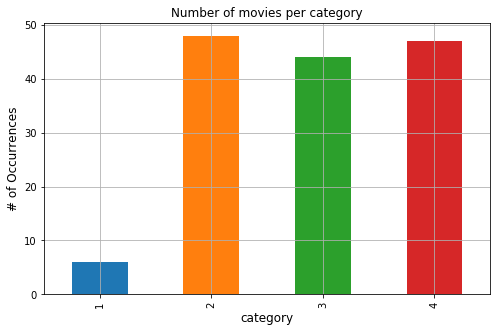

In [18]:
df_stats.plot(x='category', y='number_of_comments', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of movies per category")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)

In [21]:
print('Number of missing comments in comment text:')
data['String'].isnull().sum()

Number of missing comments in comment text:


0

In [22]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [24]:
data['String'] = data['String'].map(lambda com : clean_text(com))
#data['String'][0]

In [25]:
categories = ['1', '2', '3', '4']
train, test = train_test_split(data, random_state=42, test_size=0.33, shuffle=True)
X_train = train.String
X_test = test.String
print(X_train.shape)
print(X_test.shape)

(97,)
(48,)


In [26]:
# Define a pipeline combining a text feature extractor with multi lable classifier
NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    NB_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = NB_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))

... Processing 1
Test accuracy is 0.9375
... Processing 2
Test accuracy is 0.6666666666666666
... Processing 3
Test accuracy is 0.75
... Processing 4
Test accuracy is 0.6458333333333334


In [27]:
SVC_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),
            ])
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    SVC_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = SVC_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))


... Processing 1
Test accuracy is 0.9375
... Processing 2
Test accuracy is 0.6875
... Processing 3
Test accuracy is 0.75
... Processing 4
Test accuracy is 0.7708333333333334


In [28]:
LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    LogReg_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = LogReg_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))

... Processing 1


/Users/nikki/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Test accuracy is 0.9375
... Processing 2
Test accuracy is 0.6666666666666666
... Processing 3
Test accuracy is 0.75
... Processing 4
Test accuracy is 0.6458333333333334


# Data Cleaning

In [94]:
data['word_count'] = data['String'].apply(lambda x: len(str(x).split(" ")))
data['word_count'].describe()

count      145.000000
mean     16643.517241
std       7931.929634
min          1.000000
25%      10965.000000
50%      14797.000000
75%      22057.000000
max      43051.000000
Name: word_count, dtype: float64

In [95]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['stopwords'] = data['String'].apply(lambda x: len([x for x in x.split() if x in stop]))
data[['stopwords']].head()

,stopwords
0,7635
1,9673
2,11945
3,6406
4,8801


In [96]:
data['String'] = data['String'].apply(lambda x: " ".join(x.lower() for x in x.split()))
data['String'].head()

0    this film was great. my all-time favourite mov...
1    easily the best christmas movie of all time. i...
2    once upon a time in the west is a grand, poign...
3    easily one of the best movies of all time. fro...
4    i was blown away by amelie even though there w...
Name: String, dtype: object

In [97]:
data['String'] = data['String'].str.replace('[^\w\s]','')
data['String'].head()                            

0    this film was great my alltime favourite movie...
1    easily the best christmas movie of all time it...
2    once upon a time in the west is a grand poigna...
3    easily one of the best movies of all time from...
4    i was blown away by amelie even though there w...
Name: String, dtype: object

In [98]:
data['String'] = data['String'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
data['String'].head() 

0    film great alltime favourite movie intense loo...
1    easily best christmas movie time movie watch c...
2    upon time west grand poignant gloriously epic ...
3    easily one best movies time brilliant cast pow...
4    blown away amelie even though substantial hype...
Name: String, dtype: object

### Common Words

In [99]:
freq = pd.Series(' '.join(data['String']).split()).value_counts()[:10]
freq

movie     30312
film      19649
one       13393
good      11839
like       9360
great      9136
really     7363
time       7043
funny      6765
story      6514
dtype: int64

### Rare Words

In [100]:
freq = pd.Series(' '.join(data['String']).split()).value_counts()[-50:]
#freq

In [101]:
freq = list(freq.index)
data['String'] = data['String'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
data['String'].head()

0    film great alltime favourite movie intense loo...
1    easily best christmas movie time movie watch c...
2    upon time west grand poignant gloriously epic ...
3    easily one best movies time brilliant cast pow...
4    blown away amelie even though substantial hype...
Name: String, dtype: object

In [102]:
from textblob import TextBlob
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/nikki/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [103]:
TextBlob(data['String'][1]).words

WordList(['easily', 'best', 'christmas', 'movie', 'time', 'movie', 'watch', 'christmas', 'eve', 'every', 'year', 'shouldnt', 'watched', 'holidays', 'movie', 'watched', 'year', 'round', 'shows', 'life', 'man', 'overcomes', 'one', 'biggest', 'feats', 'allows', 'audience', 'step', 'back', 'question', 'whether', 'need', 'change', 'movie', 'truly', 'wonderful', 'watch', 'every', 'year', 'around', 'christmas', 'quite', 'simply', 'one', 'best', 'movies', 'great', 'acting', 'great', 'story', 'absolute', 'classic', 'dont', 'like', 'black', 'white', 'films', 'even', 'made', 'colour', 'film', 'tops', 'love', 'beautiful', 'watch', 'unlike', 'idiots', 'dont', 'think', 'best', 'movie', 'ever', 'made', 'name', 'better', 'equal', 'masterpiece', 'movie', 'besides', 'gone', 'wind', 'good', 'bad', 'ugly', 'among', 'best', 'films', 'ever', 'made', 'movie', 'makes', 'christmas', 'every', 'year', 'great', 'cast', 'great', 'story', 'wonderful', 'message', 'life', 'things', 'really', 'matter', '3', 'though', 

In [104]:
TextBlob(data['String'][0]).ngrams(5)

[WordList(['film', 'great', 'alltime', 'favourite', 'movie']),
 WordList(['great', 'alltime', 'favourite', 'movie', 'intense']),
 WordList(['alltime', 'favourite', 'movie', 'intense', 'look']),
 WordList(['favourite', 'movie', 'intense', 'look', 'hard']),
 WordList(['movie', 'intense', 'look', 'hard', 'family']),
 WordList(['intense', 'look', 'hard', 'family', 'couldnt']),
 WordList(['look', 'hard', 'family', 'couldnt', 'get']),
 WordList(['hard', 'family', 'couldnt', 'get', 'never']),
 WordList(['family', 'couldnt', 'get', 'never', 'liked']),
 WordList(['couldnt', 'get', 'never', 'liked', 'gangster']),
 WordList(['get', 'never', 'liked', 'gangster', 'movies']),
 WordList(['never', 'liked', 'gangster', 'movies', 'however']),
 WordList(['liked', 'gangster', 'movies', 'however', 'im']),
 WordList(['gangster', 'movies', 'however', 'im', 'saying']),
 WordList(['movies', 'however', 'im', 'saying', 'bad']),
 WordList(['however', 'im', 'saying', 'bad', 'movie']),
 WordList(['im', 'saying', 'b

In [105]:
data.head()

,String,rating,word_count,stopwords
0,film great alltime favourite movie intense loo...,4,19786,7635
1,easily best christmas movie time movie watch c...,4,23997,9673
2,upon time west grand poignant gloriously epic ...,4,29514,11945
3,easily one best movies time brilliant cast pow...,4,16172,6406
4,blown away amelie even though substantial hype...,4,22057,8801


## Sentiment

In [106]:
data['sentiment'] = data['String'].apply(lambda x: TextBlob(x).sentiment[0] )
data.head()

,String,rating,word_count,stopwords,sentiment
0,film great alltime favourite movie intense loo...,4,19786,7635,0.298368
1,easily best christmas movie time movie watch c...,4,23997,9673,0.301614
2,upon time west grand poignant gloriously epic ...,4,29514,11945,0.219304
3,easily one best movies time brilliant cast pow...,4,16172,6406,0.290716
4,blown away amelie even though substantial hype...,4,22057,8801,0.231462


## Lemmatization

In [107]:
from textblob import Word
data['String'] = data['String'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
data['String'].head()

0    film great alltime favourite movie intense loo...
1    easily best christmas movie time movie watch c...
2    upon time west grand poignant gloriously epic ...
3    easily one best movie time brilliant cast powe...
4    blown away amelie even though substantial hype...
Name: String, dtype: object

In [108]:
data.head()

,String,rating,word_count,stopwords,sentiment
0,film great alltime favourite movie intense loo...,4,19786,7635,0.298368
1,easily best christmas movie time movie watch c...,4,23997,9673,0.301614
2,upon time west grand poignant gloriously epic ...,4,29514,11945,0.219304
3,easily one best movie time brilliant cast powe...,4,16172,6406,0.290716
4,blown away amelie even though substantial hype...,4,22057,8801,0.231462


In [164]:
df = data.drop(['word_count','stopwords','sentiment'], axis=1)
counts = []
categories = list(df.columns.values)
for i in categories:
    counts.append((i, df[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_reviews'])
df_stats

,category,number_of_reviews
0,String,film great alltime favourite movie intense loo...
1,rating,422


# Model

In [114]:
import nltk
from nltk.tokenize import word_tokenize
reviews = data.String.str.cat(sep=' ')

In [115]:
#function to split text into word
tokens = word_tokenize(reviews)
vocabulary = set(tokens)
print(len(vocabulary))
frequency_dist = nltk.FreqDist(tokens)
sorted(frequency_dist,key=frequency_dist.__getitem__, reverse=True)[0:50]

63589


['movie',
 'film',
 'one',
 'good',
 'like',
 'great',
 'time',
 'really',
 'character',
 'story',
 'funny',
 'make',
 'love',
 'best',
 'see',
 'well',
 'get',
 'watch',
 'much',
 'even',
 'still',
 'first',
 'bad',
 'anus',
 'scene',
 'comedy',
 'would',
 'ever',
 'dont',
 'way',
 'performance',
 'think',
 'made',
 'better',
 'fun',
 'also',
 'plot',
 'thing',
 'seen',
 'pretty',
 'could',
 'acting',
 'cast',
 'action',
 'life',
 'end',
 'people',
 'classic',
 'lot',
 'go']

# Split Data

In [145]:
labels = data['rating']
features = data
features = data.drop(['rating'], axis=1)
print('Lables = ', len(labels))
print('Features = ', len(features))

Lables =  145
Features =  145


In [146]:
from sklearn.model_selection import train_test_split

In [147]:
features_train, features_test, train_labels, test_labels = train_test_split( 
    features, labels, #divde the features data and associated lables into training and testing sets
    test_size=0.20, random_state=42)

In [148]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word',
 stop_words= 'english',ngram_range=(1,1))
train_vect = tfidf.fit_transform(features_train['String'])
test_vect = tfidf.fit_transform(features_test['String'])



In [155]:
test_vect

<29x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 18505 stored elements in Compressed Sparse Row format>

In [158]:
features_train['matrix'] = train_vect

/Users/nikki/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [162]:
features_train.drop(['matrix'],axis = 1)

,String,word_count,stopwords,sentiment
9,epic final legend star war vi best 80 star war...,27805,11359,0.213076
4,blown away amelie even though substantial hype...,22057,8801,0.231462
26,often claimed scariest movie ever made hard li...,31422,12611,0.131291
120,80 humor lot classic line greatest acting stil...,8945,3419,0.139719
125,film unwatchable think adorable cheesy christm...,7235,2650,0.158771
16,epitome cinematic perfection jeff barnes 12717...,33283,13297,0.215675
10,rewatched nov 2018 still good quintessential c...,27578,11291,0.263632
118,agree say business going theater lousy sequel ...,10767,4342,0.183366
60,natalie portman great fact one stand cast even...,16226,6216,0.203617
67,movie show two parent struggle raise 12 child ...,9220,3637,0.216936


In [149]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(train_vect, train_labels)

In [153]:
from sklearn import metrics
predicted = clf.predict(test_vect)
print(metrics.accuracy_score(test_labels,predicted))

0.27586206896551724


## TF-IDF 

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word',
 stop_words= 'english',ngram_range=(1,1))
train_vect = tfidf.fit_transform(data['String'])

train_vect

<145x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 91921 stored elements in Compressed Sparse Row format>

### Bag of Words

In [35]:
from sklearn.feature_extraction.text import CountVectorizer
bow = CountVectorizer(max_features=1000, lowercase=True, ngram_range=(1,1),analyzer = "word")
train_bow = bow.fit_transform(data['String'])
train_bow

<145x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 98841 stored elements in Compressed Sparse Row format>

## Sentiment

In [36]:
data['String'][:5].apply(lambda x: TextBlob(x).sentiment)

0    (0.29836807413352373, 0.5640751870632481)
1     (0.3016142466305182, 0.5812395626111169)
2    (0.21930412601843313, 0.5374867579380078)
3     (0.2907164797898891, 0.5813378754202674)
4    (0.23146236208932214, 0.5805907836890075)
Name: String, dtype: object

In [80]:
data['sentiment'] = data['String'].apply(lambda x: TextBlob(x).sentiment[0] )
data.head()

,String,rating,word_count,stopwords,sentiment
0,film great alltime favourite movie intense loo...,4,19786,7635,0.298368
1,easily best christmas movie time movie watch c...,4,23997,9673,0.301614
2,upon time west grand poignant gloriously epic ...,4,29514,11945,0.219304
3,easily one best movies time brilliant cast pow...,4,16172,6406,0.290716
4,blown away amelie even though substantial hype...,4,22057,8801,0.231462


## Model

In [ ]:
from sklearn.cluster import KMeans
num_clusters = 15
km = KMeans(n_clusters=num_clusters, init='random', n_init=1, verbose=1, random_state=3)

In [ ]:
km

In [ ]:
km.fit(vectorized)

In [ ]:
indices = [i for i in range(len(km.labels_)) if km.labels_[i] == 1]
len(indices)
#print (len(km.labels_[42]))

In [ ]:
len(km.labels_)

In [ ]:
for k in range(20):
    indices = [i for i in range(len(km.labels_)) if km.labels_[i] == k]
    print("Cluster number: " , k)
    print("Length of Cluster: ", len(indices))
    
    line = ""
    count = 0
    for doc in range(len(indices)):
        sent = allText[indices[doc]]
        tweet = sent.lower()
        #print(type(tweet))
        line += tweet
        #print (line)
        if count <=5:
            print("Tweet number : ", count)
            print(tweet)
            count = count + 1
    
    all_words = []
    all_words = line.split()
    #all_words.extend(words)
    for a in all_words:
        a.lower()
            
    resulting_count = collections.Counter(x for x in all_words if x not in stopwords)
    print("Most common words for Cluster ", k, " are: ")
    for a in resulting_count.most_common(10):
        print (a[0] , a[1])
        
    print()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(allText) #fit the vectorizer to synopses

print(tfidf_matrix.shape)

In [ ]:
from scipy.cluster.hierarchy import ward, dendrogram
print(0)
linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances
print(1)

fig, ax = plt.subplots(figsize=(15, 20)) # set size
print(2)
ax = dendrogram(linkage_matrix, orientation="right", labels=titles);

print(3)
plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout
print(4)
#uncomment below to save figure
plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters
print(5)

In [ ]:
from sklearn.datasets import load_files
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer
from __future__ import print_function
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning, module='.*/IPython/.*')
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

In [ ]:
def print_top_words(model, features, n):
    '''prints the n top words per topic.'''
    for topicID, topic in enumerate(model.components_):
        print('Topic #%d:' % topicID)
        print(', '.join([features[i] for i in topic.argsort()[:-n-1:-1]]))
        print()

In [ ]:
# create the models
vectorizer = CountVectorizer(max_features=1000, stop_words='english', decode_error='ignore')
lda = LDA(n_topics=10, max_iter=5, learning_method='online', learning_offset=50., random_state=0)
In [54]:


In [39]:
def do_LDA(directory, vectorizer, lda, n):
    '''Does LDA topic modeling on a given dataset indicated by directory, using inputted vectorizer and 
    lda model. Calls print_top_words to make the results coherent. Returns the matrix so that the 
    visualization can be generated.'''
    train = load_files(directory)
    matrix = vectorizer.fit_transform(train.data)
    lda.fit(matrix)
    features = vectorizer.get_feature_names()
    print_top_words(lda, features, n)
    return matrix


matrix = do_LDA('DIRECTORY', vectorizer, lda, 15)

NameError: name 'vectorizer' is not defined